Hello this is the project workbook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


<function matplotlib.pyplot.show(close=None, block=None)>

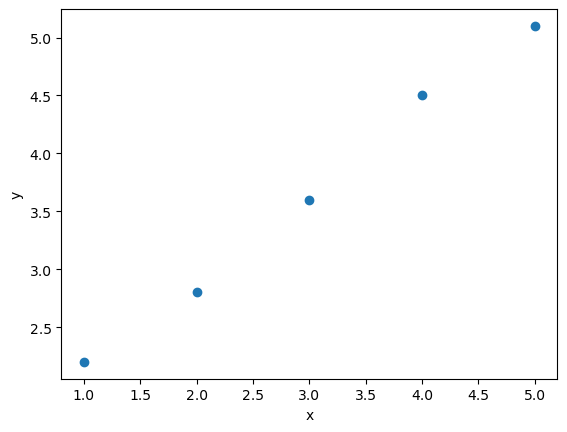

In [2]:
x=np.array([1,2,3,4,5])
y=np.array([2.2,2.8,3.6,4.5,5.1])



plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')     
plt.show

26.9.25

Ok so I got everything working on new laptop

Had a look at BNL NNDC isotope chart and beginng to look in to exfor database and some of the literature


consutling https://www-nds.iaea.org/nrdc/basics/exfor-basics-1.html

found this https://www-nds.iaea.org/exfor/x4stat/exfor_stat.htm

and this https://github.com/afedynitch/x4i3/tree/master

file:///Users/glsw/Downloads/x4i.pdf

In [3]:
import json as json
import requests
import x4i3 as x4i3
import time

Using database version x4i3_X4-2023-04-29 located in: /opt/anaconda3/envs/env1/lib/python3.11/site-packages/x4i3/data


In [4]:
from x4i3 import exfor_manager, exfor_entry

In [7]:
def calculate_total_datapoints(isotope, quantity='SIG'):
    """
    Queries the EXFOR database for a specific isotope and quantity,
    then retrieves the parsed data and counts the total number of data points.
    (Final corrected version)
    """
    total_datapoints = 0
    
    try:
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully.")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        print("Please ensure you have run the setupEXFORdb.py script first.")
        return None

    print(f"Querying for target='{isotope}' and quantity='{quantity}'...")
    query_results = db.query(target=isotope, quantity=quantity)
    
    if not query_results:
        print("No entries found matching the criteria.")
        return 0
        
    entry_ids = list(query_results.keys())
    print(f"Found {len(entry_ids)} matching entries. Now processing data...")

    for entry_id in entry_ids:
        try:
            # --- FIX IS HERE ---
            # db.retrieve() returns a dictionary containing the ALREADY PARSED entry object.
            # We do not need to parse it again.
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id] # This is the X4Entry object we need.
            
            # Now we can use the object directly.
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
                
        except Exception as e:
            print(f"Could not process entry {entry_id}: {e}")
            
    return total_datapoints

In [ ]:
# --- Configuration and Execution ---

isotope_to_find = "U-235"
total_points = calculate_total_datapoints(isotope_to_find)

if total_points is not None:
    print("\n--- Analysis Complete ---")
    print(f"Found a total of {total_points} cross section data points for {isotope_to_find}.")

Database manager initialized successfully.
Querying for target='U-235' and quantity='SIG'...
Found 579 matching entries. Now processing data...


In [ ]:
import os
import re
import pprint
from x4i3 import exfor_manager, exfor_entry

# --- Configuration ---
# Set this path to the root of your EXFOR database (the 'entry' folder)
db_root_path = '/Users/glsw/python/entry/'

# Set the environment variable so the x4i3 library can find the database
os.environ['X4I_DB_ROOT'] = db_root_path

In [ ]:
def discover_all_isotopes(directory):
    """
    Scans the entire local EXFOR database to find all unique target isotopes.
    """
    print("Starting Phase 1: Discovering all unique isotopes in the database...")
    unique_isotopes = set()
    db_manager = exfor_manager.X4DBManagerDefault()
    
    # Regex to find patterns like '92-U-235' in reaction strings
    isotope_pattern = re.compile(r'\((\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    all_files = [os.path.join(root, filename) for root, _, files in os.walk(directory) for filename in files]
    print(f"Found {len(all_files)} files to scan...")

    for i, file_path in enumerate(all_files):
        if (i + 1) % 1000 == 0:
            print(f"  ...scanned {i+1}/{len(all_files)} files...")
        try:
            entry_id = os.path.splitext(os.path.basename(file_path))[0]
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            for subentry_data in parsed_entry.values():
                if "REACTION" in subentry_data:
                    reaction_string = str(subentry_data["REACTION"])
                    match = isotope_pattern.search(reaction_string)
                    if match:
                        unique_isotopes.add(match.group(1))
        except Exception:
            continue
            
    print(f"Discovery complete. Found {len(unique_isotopes)} unique isotopes.")
    return sorted(list(unique_isotopes))

In [ ]:
def calculate_total_datapoints(isotope, db_manager, quantity='SIG'):
    """
    Queries the EXFOR database for a SINGLE isotope and quantity,
    then counts the total number of data points using a provided db_manager.
    """
    total_datapoints = 0
    query_results = db_manager.query(target=isotope, quantity=quantity)
    
    if not query_results:
        return 0
        
    entry_ids = list(query_results.keys())

    for entry_id in entry_ids:
        try:
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
        except Exception:
            continue
            
    return total_datapoints

In [ ]:
# --- Main Execution Script ---

all_results = {}

# --- PHASE 1: DISCOVERY ---
isotopes_to_process = discover_all_isotopes(db_root_path)

if isotopes_to_process:
    # --- PHASE 2: COUNTING ---
    print("\nStarting Phase 2: Counting cross section data for each isotope...")
    
    db = exfor_manager.X4DBManagerDefault()
    
    total_isotopes = len(isotopes_to_process)
    for i, isotope in enumerate(isotopes_to_process):
        print(f"  ({i+1}/{total_isotopes}) Processing {isotope}...")
        count = calculate_total_datapoints(isotope, db)
        if count > 0:
            all_results[isotope] = count
            
    print("\n--- Analysis Complete ---")
    print("Total cross section data points found per isotope:")
    
    pprint.pprint(all_results)
else:
    print("Could not discover any isotopes to process.")

Starting Phase 1: Discovering all unique isotopes in the database...
Found 26722 files to scan...
  ...scanned 1000/26722 files...
  ...scanned 2000/26722 files...
  ...scanned 3000/26722 files...
  ...scanned 4000/26722 files...
  ...scanned 5000/26722 files...
  ...scanned 6000/26722 files...
  ...scanned 7000/26722 files...
  ...scanned 8000/26722 files...
  ...scanned 9000/26722 files...
  ...scanned 10000/26722 files...
  ...scanned 11000/26722 files...
  ...scanned 12000/26722 files...
  ...scanned 13000/26722 files...
  ...scanned 14000/26722 files...
  ...scanned 15000/26722 files...
  ...scanned 16000/26722 files...
  ...scanned 17000/26722 files...
  ...scanned 18000/26722 files...
  ...scanned 19000/26722 files...
  ...scanned 20000/26722 files...
  ...scanned 21000/26722 files...
  ...scanned 22000/26722 files...
  ...scanned 23000/26722 files...
  ...scanned 24000/26722 files...
  ...scanned 25000/26722 files...
  ...scanned 26000/26722 files...
Discovery complete. Found 0

In [ ]:
import os
import re
import pprint
from x4i3 import exfor_manager

# --- Configuration ---
# Set this path to the root of your EXFOR database (the 'entry' folder)
db_root_path = '/Users/glsw/python/entry/'

# Set the environment variable so the x4i3 library can find the database
os.environ['X4I_DB_ROOT'] = db_root_path

In [ ]:
def analyze_full_database(directory):
    """
    Scans an entire local EXFOR database in a single pass. For each isotope found,
    it stores a list of entries it appears in and the total count of cross 
    section data points.
    """
    print("Starting full database analysis...")
    
    # This will be our final data structure
    # Format: { 'isotope': {'entries': {'id1', 'id2'}, 'datapoint_count': 123} }
    results = {}
    
    # Initialize the manager once for efficiency
    db_manager = exfor_manager.X4DBManagerDefault()
    
    # Regex to find patterns like '92-U-235' in reaction strings
    isotope_pattern = re.compile(r'\((\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    all_files = [os.path.join(root, filename) for root, _, files in os.walk(directory) for filename in files]
    total_files = len(all_files)
    print(f"Found {total_files} files to analyze...")

    for i, file_path in enumerate(all_files):
        if (i + 1) % 1000 == 0:
            print(f"  ...processed {i+1}/{total_files} files...")
        
        try:
            entry_id = os.path.splitext(os.path.basename(file_path))[0]
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            # Process each subentry within the file
            for subentry_data in parsed_entry.values():
                if "REACTION" not in subentry_data:
                    continue
                
                reaction_string = str(subentry_data["REACTION"])
                
                # 1. Discover the isotope
                match = isotope_pattern.search(reaction_string)
                if not match:
                    continue # Skip if no valid isotope found in this subentry
                
                isotope = match.group(1)
                
                # 2. Initialize and store the entry location for this isotope
                # setdefault is an efficient way to create the entry if it doesn't exist
                results.setdefault(isotope, {'entries': set(), 'datapoint_count': 0})
                results[isotope]['entries'].add(entry_id)
                
                # 3. Check for and count cross section data points
                is_cross_section = ",SIG" in reaction_string.upper()
                has_data_table = "DATA" in subentry_data and "DATA" in subentry_data["DATA"]
                
                if is_cross_section and has_data_table:
                    num_rows = len(subentry_data["DATA"]["DATA"])
                    results[isotope]['datapoint_count'] += num_rows

        except Exception as e:
            # If a file is corrupted or fails to parse, log it and continue
            # print(f"  Skipping file {file_path} due to error: {e}")
            continue
    
    print(f"Analysis complete. Processed {total_files} files.")
    return results

In [ ]:
# --- Main Execution Script ---

# Run the main analysis function
final_results = analyze_full_database(db_root_path)

if final_results:
    print("\n--- Analysis Complete ---")
    print("Summary of discovered isotopes, their locations, and cross section data point counts:")
    
    # Convert sets to sorted lists for cleaner final output
    for isotope in final_results:
        final_results[isotope]['entries'] = sorted(list(final_results[isotope]['entries']))

    # Use pprint to print the final dictionary beautifully
    pprint.pprint(final_results)
else:
    print("Analysis finished, but no data was successfully processed.")

Starting full database analysis...
Found 26722 files to analyze...
  ...processed 1000/26722 files...
  ...processed 2000/26722 files...
  ...processed 3000/26722 files...
  ...processed 4000/26722 files...
  ...processed 5000/26722 files...
  ...processed 6000/26722 files...
  ...processed 7000/26722 files...
  ...processed 8000/26722 files...
  ...processed 9000/26722 files...
  ...processed 10000/26722 files...
  ...processed 11000/26722 files...
  ...processed 12000/26722 files...
  ...processed 13000/26722 files...
  ...processed 14000/26722 files...
  ...processed 15000/26722 files...
  ...processed 16000/26722 files...
  ...processed 17000/26722 files...
  ...processed 18000/26722 files...
  ...processed 19000/26722 files...
  ...processed 20000/26722 files...
  ...processed 21000/26722 files...
  ...processed 22000/26722 files...
  ...processed 23000/26722 files...
  ...processed 24000/26722 files...
  ...processed 25000/26722 files...
  ...processed 26000/26722 files...
Analys

In [5]:
import re
import pprint
from x4i3 import exfor_manager, exfor_entry

In [6]:
def analyze_inbuilt_database(quantity='SIG'):
    """
    Queries the entire inbuilt EXFOR database for a specific quantity, discovers
    all associated isotopes, and counts their total data points.
    (Final corrected version)
    """
    results = {}
    
    try:
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully (using built-in DB).")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        return None

    print(f"Performing a broad query for all entries with quantity='{quantity}'...")
    query_results = db.query(quantity=quantity)
    
    if not query_results:
        print("Query returned no entries.")
        return {}
        
    entry_ids = list(query_results.keys())
    total_entries = len(entry_ids)
    print(f"Query successful. Found {total_entries} entries to process...")

    # --- FIX IS HERE ---
    # The '^' at the start of the old regex was too strict. This new, more
    # flexible pattern finds the Z-SYM-A format ANYWHERE in the string.
    isotope_pattern = re.compile(r'(\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    for i, entry_id in enumerate(entry_ids):
        if (i + 1) % 500 == 0:
            print(f"  ...processed {i+1}/{total_entries} entries...")
        try:
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            for subentry_data in parsed_entry.values():
                if "REACTION" not in subentry_data:
                    continue
                
                reaction_string = str(subentry_data["REACTION"])
                
                if ",SIG" not in reaction_string.upper():
                    continue

                match = isotope_pattern.search(reaction_string)
                if not match:
                    continue
                
                isotope = match.group(1)
                
                if isotope not in results:
                    print(f"  --> Discovered new isotope: {isotope}")
                
                if "DATA" in subentry_data and "DATA" in subentry_data["DATA"]:
                    num_rows = len(subentry_data["DATA"]["DATA"])
                    results[isotope] = results.get(isotope, 0) + num_rows
        except Exception:
            continue
            
    print(f"Analysis complete. Processed {total_entries} entries.")
    return results

In [ ]:
        # --- Main Execution Script ---

final_results = analyze_inbuilt_database()

if final_results is not None:
    print("\n--- Analysis Complete ---")
    print("Total cross section data points found per isotope in the built-in database:")
    
    pprint.pprint(final_results)
else:
    print("Analysis could not be completed due to an error.")

Database manager initialized successfully (using built-in DB).
Performing a broad query for all entries with quantity='SIG'...
Query successful. Found 13485 entries to process...
  ...processed 500/13485 entries...
  ...processed 1000/13485 entries...
  ...processed 1500/13485 entries...
  ...processed 2000/13485 entries...
  ...processed 2500/13485 entries...
  ...processed 3000/13485 entries...
  ...processed 3500/13485 entries...
  ...processed 4000/13485 entries...
  ...processed 4500/13485 entries...
  ...processed 5000/13485 entries...
  ...processed 5500/13485 entries...
  ...processed 6000/13485 entries...
  ...processed 6500/13485 entries...
  ...processed 7000/13485 entries...
  ...processed 7500/13485 entries...
  ...processed 8000/13485 entries...
  ...processed 8500/13485 entries...
  ...processed 9000/13485 entries...
  ...processed 9500/13485 entries...
  ...processed 10000/13485 entries...
  ...processed 10500/13485 entries...


##BREAK

In [3]:
from x4i3 import exfor_manager, exfor_entry

def calculate_total_datapoints(isotope, quantity='SIG'):
    """
    Queries the EXFOR database for a specific isotope and quantity,
    then retrieves the parsed data and counts the total number of data points.
    (Final corrected version)
    """
    total_datapoints = 0
    
    try:
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully.")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        print("Please ensure you have run the setupEXFORdb.py script first.")
        return None

    print(f"Querying for target='{isotope}' and quantity='{quantity}'...")
    query_results = db.query(target=isotope, quantity=quantity)
    
    if not query_results:
        print("No entries found matching the criteria.")
        return 0
        
    entry_ids = list(query_results.keys())
    print(f"Found {len(entry_ids)} matching entries. Now processing data...")

    for entry_id in entry_ids:
        try:
            # --- FIX IS HERE ---
            # db.retrieve() returns a dictionary containing the ALREADY PARSED entry object.
            # We do not need to parse it again.
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id] # This is the X4Entry object we need.
            
            # Now we can use the object directly.
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
                
        except Exception as e:
            print(f"Could not process entry {entry_id}: {e}")
            
    return total_datapoints

Using database version x4i3_X4-2023-04-29 located in: /opt/anaconda3/envs/env1/lib/python3.11/site-packages/x4i3/data


In [4]:
# --- Configuration and Execution ---

isotope_to_find = "U-235"
total_points = calculate_total_datapoints(isotope_to_find)

if total_points is not None:
    print("\n--- Analysis Complete ---")
    print(f"Found a total of {total_points} cross section data points for {isotope_to_find}.")

Database manager initialized successfully.
Querying for target='U-235' and quantity='SIG'...
Found 579 matching entries. Now processing data...

--- Analysis Complete ---
Found a total of 710127 cross section data points for U-235.


In [5]:
# --- Configuration and Execution ---

isotope_to_find = "U-238"
total_points = calculate_total_datapoints(isotope_to_find)

if total_points is not None:
    print("\n--- Analysis Complete ---")
    print(f"Found a total of {total_points} cross section data points for {isotope_to_find}.")

Database manager initialized successfully.
Querying for target='U-238' and quantity='SIG'...
Found 688 matching entries. Now processing data...

--- Analysis Complete ---
Found a total of 735063 cross section data points for U-238.


In [6]:
import re
import pprint
from x4i3 import exfor_manager, exfor_entry

def analyze_inbuilt_database(quantity='SIG'):
    """
    Queries the entire inbuilt EXFOR database for a specific quantity, discovers
    all associated isotopes, and counts their total data points.
    """
    # This will be our final data structure: { 'isotope': count }
    results = {}
    
    try:
        # Initialize the manager to use the built-in database
        db = exfor_manager.X4DBManagerDefault()
        print("Database manager initialized successfully (using built-in DB).")
    except Exception as e:
        print(f"Failed to initialize database manager: {e}")
        return None

    # 1. Perform a single, broad query to find ALL entries with the specified quantity
    print(f"Performing a broad query for all entries with quantity='{quantity}'...")
    query_results = db.query(quantity=quantity)
    
    if not query_results:
        print("Query returned no entries. The built-in database might be empty or unconfigured.")
        return {}
        
    entry_ids = list(query_results.keys())
    total_entries = len(entry_ids)
    print(f"Query successful. Found {total_entries} entries to process...")

    # Regex to find the Z-SYM-A format (e.g., 92-U-235) anywhere in the string
    isotope_pattern = re.compile(r'(\d{1,3}-[A-Z]{1,3}-\d{1,3})')

    # 2. Process every entry found in the query
    for i, entry_id in enumerate(entry_ids):
        if (i + 1) % 500 == 0:
            print(f"  ...processed {i+1}/{total_entries} entries...")
        try:
            retrieved_data = db.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            
            # Process each subentry within the entry
            for subentry_data in parsed_entry.values():
                if "REACTION" not in subentry_data:
                    continue
                
                reaction_string = str(subentry_data["REACTION"])
                
                # We only care about subentries that are explicitly cross-section
                if ",SIG" not in reaction_string.upper():
                    continue

                # Discover the isotope in this subentry
                match = isotope_pattern.search(reaction_string)
                if not match:
                    continue
                
                isotope = match.group(1)
                
                # Announce when a new isotope is found for the first time
                if isotope not in results:
                    print(f"  --> Discovered new isotope: {isotope}")
                
                # Count the data points if a data table exists
                if "DATA" in subentry_data and "DATA" in subentry_data["DATA"]:
                    num_rows = len(subentry_data["DATA"]["DATA"])
                    # Add the count to our results dictionary
                    results[isotope] = results.get(isotope, 0) + num_rows
        except Exception:
            # If a single entry is corrupted or fails, skip it
            continue
            
    print(f"Analysis complete. Processed {total_entries} entries.")
    return results

In [7]:
# --- Main Execution Script ---

final_results = analyze_inbuilt_database()

if final_results is not None:
    print("\n--- Analysis Complete ---")
    print("Total cross section data points found per isotope in the built-in database:")
    
    # Use pprint to print the final dictionary beautifully
    pprint.pprint(final_results)
else:
    print("Analysis could not be completed due to an error.")

Database manager initialized successfully (using built-in DB).
Performing a broad query for all entries with quantity='SIG'...
Query successful. Found 13485 entries to process...
  ...processed 500/13485 entries...
  ...processed 1000/13485 entries...
  ...processed 1500/13485 entries...
  ...processed 2000/13485 entries...
  ...processed 2500/13485 entries...
  ...processed 3000/13485 entries...
  ...processed 3500/13485 entries...
  ...processed 4000/13485 entries...
  ...processed 4500/13485 entries...
  ...processed 5000/13485 entries...
  ...processed 5500/13485 entries...
  ...processed 6000/13485 entries...
  ...processed 6500/13485 entries...
  ...processed 7000/13485 entries...
  ...processed 7500/13485 entries...
  ...processed 8000/13485 entries...
  ...processed 8500/13485 entries...
  ...processed 9000/13485 entries...
  ...processed 9500/13485 entries...
  ...processed 10000/13485 entries...
  ...processed 10500/13485 entries...


KeyboardInterrupt: 

In [8]:
import numpy as np
import pprint
from x4i3 import exfor_manager, exfor_entry

# A predefined list of isotopes to query one by one.
# You can expand this list with any other isotopes you are interested in.
isotopes_to_query = [
    # Light Isotopes
    'H-1', 'H-2', 'H-3', 'HE-3', 'HE-4', 'LI-6', 'LI-7', 'BE-9', 'B-10', 'B-11',
    'C-12', 'C-13', 'N-14', 'N-15', 'O-16', 'O-17',
    
    # Structural Materials
    'NA-23', 'MG-24', 'AL-27', 'SI-28', 'P-31', 'S-32', 'CL-35', 'K-39', 'CA-40',
    'TI-48', 'V-51', 'CR-52', 'MN-55', 'FE-54', 'FE-56', 'FE-57', 'CO-59', 'NI-58',
    'NI-60', 'CU-63', 'CU-65', 'ZN-64', 'ZR-90', 'MO-95', 'W-184', 'W-186',
    
    # Fission Products & Actinides
    'SR-90', 'Y-89', 'I-127', 'XE-135', 'CS-137', 'ND-143', 'SM-149', 'EU-151',
    'TH-232', 'U-233', 'U-234', 'U-235', 'U-236', 'U-238',
    'NP-237', 'PU-238', 'PU-239', 'PU-240', 'PU-241', 'AM-241'
]

In [9]:
def calculate_total_datapoints(isotope, db_manager, quantity='SIG'):
    """
    Queries the EXFOR database for a SINGLE isotope and quantity,
    then retrieves and counts the total number of data points.
    """
    total_datapoints = 0
    query_results = db_manager.query(target=isotope, quantity=quantity)
    
    if not query_results:
        return 0
        
    entry_ids = list(query_results.keys())

    for entry_id in entry_ids:
        try:
            retrieved_data = db_manager.retrieve(ENTRY=entry_id)
            parsed_entry = retrieved_data[entry_id]
            simplified_datasets = parsed_entry.getSimplifiedDataSets()
            
            for dataset in simplified_datasets.values():
                num_rows = len(dataset.data)
                total_datapoints += num_rows
        except Exception:
            # If a single entry fails to process, skip it and continue
            continue
            
    return total_datapoints

In [10]:
# --- Main Execution Script ---

# This dictionary will store the final results
all_results_dict = {}

try:
    # Initialize the manager once to reuse in the loop for efficiency
    db = exfor_manager.X4DBManagerDefault()
    print("Database manager initialized successfully (using built-in DB).")
    
    total_isotopes = len(isotopes_to_query)
    print(f"\nBeginning query for {total_isotopes} predefined isotopes...")

    for i, isotope in enumerate(isotopes_to_query):
        count = calculate_total_datapoints(isotope, db)
        print(f"  ({i+1}/{total_isotopes}) Found {count} data points for {isotope}")
        if count > 0:
            all_results_dict[isotope] = count
            
    print("\n--- Analysis Complete ---")

    # --- Convert dictionary to a NumPy structured array ---
    if all_results_dict:
        data_list = list(all_results_dict.items())
        dt = np.dtype([('isotope', 'U12'), ('count', int)])
        numpy_results = np.array(data_list, dtype=dt)
        
        # Sort the array by the 'count' column in descending order
        numpy_results = np.sort(numpy_results, order='count')[::-1]
        
        print("Top isotopes by cross section data point count:")
        print(numpy_results)
    else:
        print("No data points found for any of the specified isotopes.")

except Exception as e:
    print(f"An error occurred during analysis: {e}")

Database manager initialized successfully (using built-in DB).

Beginning query for 62 predefined isotopes...
  (1/62) Found 125904 data points for H-1
  (2/62) Found 70534 data points for H-2
  (3/62) Found 20441 data points for H-3
  (4/62) Found 20769 data points for HE-3
  (5/62) Found 12456 data points for HE-4
  (6/62) Found 119904 data points for LI-6
  (7/62) Found 118899 data points for LI-7
  (8/62) Found 236745 data points for BE-9
  (9/62) Found 106114 data points for B-10
  (10/62) Found 87616 data points for B-11
  (11/62) Found 253593 data points for C-12
  (12/62) Found 66533 data points for C-13
  (13/62) Found 89220 data points for N-14
  (14/62) Found 28966 data points for N-15
  (15/62) Found 215031 data points for O-16
  (16/62) Found 15396 data points for O-17
  (17/62) Found 218411 data points for NA-23
  (18/62) Found 54985 data points for MG-24
  (19/62) Found 599035 data points for AL-27
  (20/62) Found 140739 data points for SI-28
  (21/62) Found 142267 data 

Preparing data for plotting...
Generating plot...

Plot has been generated and saved as 'nuclide_chart.png'


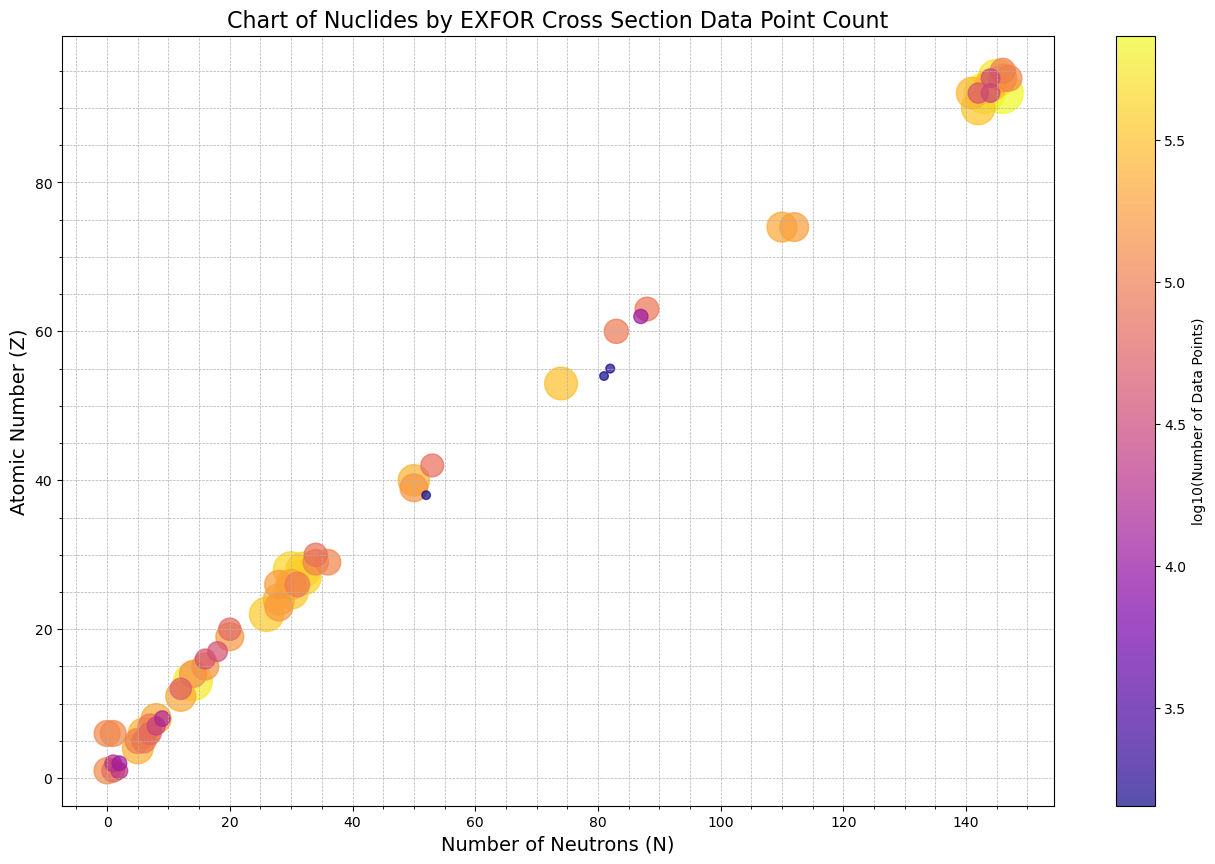

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Plotting the Results ---

# This script assumes the 'numpy_results' array from the previous cell exists.

# A lookup map to get Atomic Number (Z) from the element symbol
# This contains all the elements from our predefined query list.
element_z_map = {
    'H': 1, 'HE': 2, 'LI': 6, 'BE': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'NA': 11,
    'MG': 12, 'AL': 13, 'SI': 14, 'P': 15, 'S': 16, 'CL': 17, 'K': 19, 'CA': 20,
    'TI': 22, 'V': 23, 'CR': 24, 'MN': 25, 'FE': 26, 'CO': 27, 'NI': 28, 'CU': 29,
    'ZN': 30, 'SR': 38, 'Y': 39, 'ZR': 40, 'MO': 42, 'I': 53, 'XE': 54, 'CS': 55,
    'ND': 60, 'SM': 62, 'EU': 63, 'W': 74, 'TH': 90, 'U': 92, 'NP': 93, 'PU': 94,
    'AM': 95
}


if 'numpy_results' in locals() and len(numpy_results) > 0:
    print("Preparing data for plotting...")
    
    neutrons = []
    protons = []
    counts = []

    # Parse the 'SYM-A' isotope string
    for row in numpy_results:
        isotope_str = row['isotope']
        count = row['count']
        
        try:
            parts = isotope_str.split('-')
            symbol = parts[0].upper()
            A = int(parts[1])  # Mass Number
            
            # Use the lookup map to get Z
            Z = element_z_map[symbol] # Atomic Number (Protons)
            N = A - Z                 # Neutron Number
            
            protons.append(Z)
            neutrons.append(N)
            counts.append(count)
        except (ValueError, IndexError, KeyError):
            print(f"  Skipping malformed or unknown isotope: {isotope_str}")
            continue

    print("Generating plot...")
    
    plt.figure(figsize=(16, 10))
    
    scatter = plt.scatter(
        x=neutrons, 
        y=protons, 
        c=np.log10(counts), 
        s=[val**0.5 for val in counts],
        cmap='plasma',
        alpha=0.7
    )
    
    plt.xlabel('Number of Neutrons (N)', fontsize=14)
    plt.ylabel('Atomic Number (Z)', fontsize=14)
    plt.title('Chart of Nuclides by EXFOR Cross Section Data Point Count', fontsize=16)
    
    cbar = plt.colorbar(scatter, label='log10(Number of Data Points)')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    
    plt.savefig('nuclide_chart.png', dpi=300)
    
    print("\nPlot has been generated and saved as 'nuclide_chart.png'")

else:
    print("The 'numpy_results' array was not found or is empty. Please run the analysis cell first.")

Preparing data for plotting...
Generating plot...

Plot has been generated and saved as 'nuclide_heatmap.png'


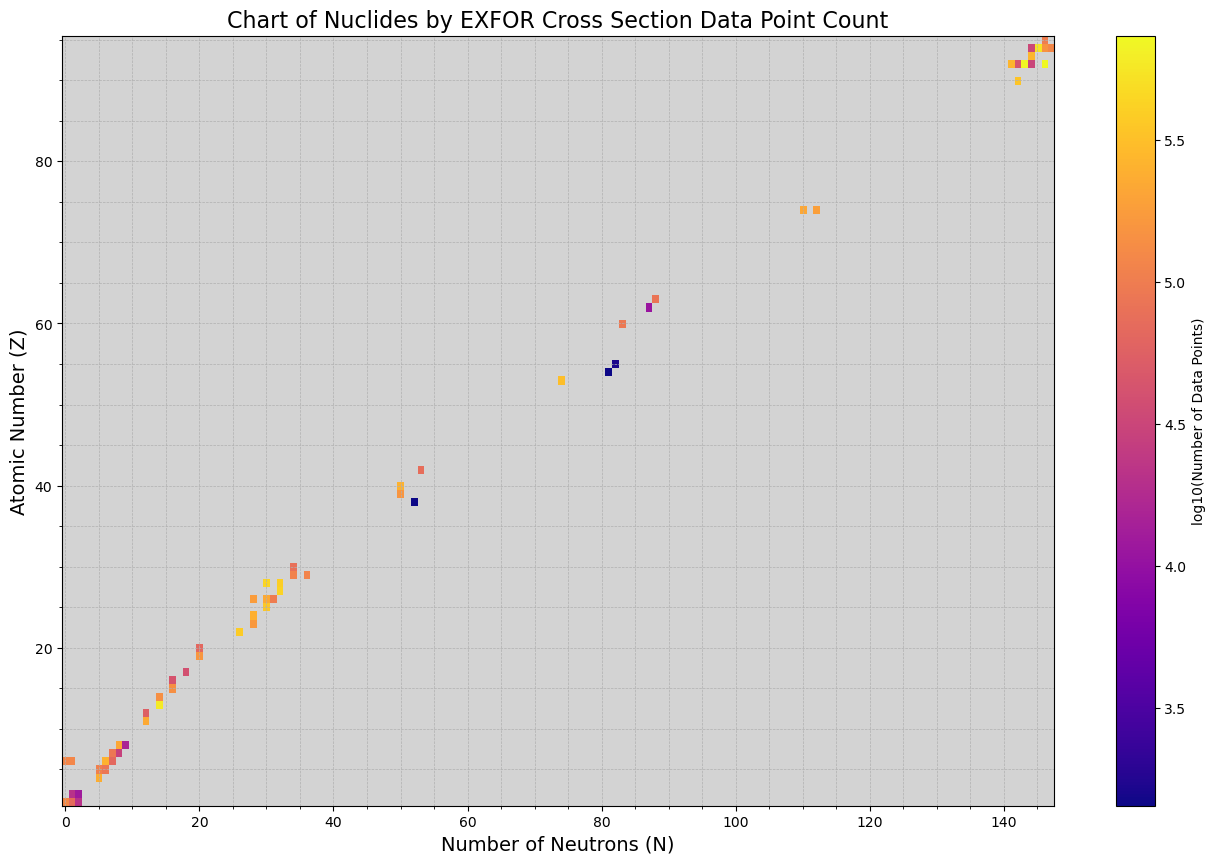

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Plotting the Results ---

# This script assumes the 'numpy_results' array from the previous cell exists.

if 'numpy_results' in locals() and len(numpy_results) > 0:
    print("Preparing data for plotting...")
    
    # A lookup map to get Atomic Number (Z) from the element symbol
    element_z_map = {
        'H': 1, 'HE': 2, 'LI': 6, 'BE': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'NA': 11,
        'MG': 12, 'AL': 13, 'SI': 14, 'P': 15, 'S': 16, 'CL': 17, 'K': 19, 'CA': 20,
        'TI': 22, 'V': 23, 'CR': 24, 'MN': 25, 'FE': 26, 'CO': 27, 'NI': 28, 'CU': 29,
        'ZN': 30, 'SR': 38, 'Y': 39, 'ZR': 40, 'MO': 42, 'I': 53, 'XE': 54, 'CS': 55,
        'ND': 60, 'SM': 62, 'EU': 63, 'W': 74, 'TH': 90, 'U': 92, 'NP': 93, 'PU': 94,
        'AM': 95
    }

    protons = []
    neutrons = []
    counts = []

    for row in numpy_results:
        try:
            parts = row['isotope'].split('-')
            symbol = parts[0].upper()
            A = int(parts[1])
            Z = element_z_map[symbol]
            N = A - Z
            
            protons.append(Z)
            neutrons.append(N)
            counts.append(row['count'])
        except (ValueError, IndexError, KeyError):
            continue

    # --- Create the 2D Grid for the Heatmap ---
    
    # 1. Determine the boundaries of our chart
    n_min, n_max = min(neutrons), max(neutrons)
    z_min, z_max = min(protons), max(protons)
    
    # 2. Create an empty grid filled with 'NaN' (Not a Number) for missing data
    grid_rows = z_max - z_min + 1
    grid_cols = n_max - n_min + 1
    heatmap_data = np.full((grid_rows, grid_cols), np.nan)
    
    # 3. Fill the grid with the log of the data points we have
    for Z, N, count in zip(protons, neutrons, counts):
        # Calculate the array index for each isotope
        row_idx = Z - z_min
        col_idx = N - n_min
        heatmap_data[row_idx, col_idx] = np.log10(count)

    print("Generating plot...")
    
    # --- Plotting the Grid ---
    
    plt.figure(figsize=(16, 10))
    
    # Use a colormap and set the color for 'NaN' values to light grey
    cmap = plt.get_cmap('plasma')
    cmap.set_bad(color='lightgray')

    # Use imshow to plot the 2D grid
    im = plt.imshow(
        heatmap_data, 
        cmap=cmap, 
        origin='lower',
        extent=[n_min - 0.5, n_max + 0.5, z_min - 0.5, z_max + 0.5],
        aspect='auto'
    )
    
    plt.xlabel('Number of Neutrons (N)', fontsize=14)
    plt.ylabel('Atomic Number (Z)', fontsize=14)
    plt.title('Chart of Nuclides by EXFOR Cross Section Data Point Count', fontsize=16)
    
    cbar = plt.colorbar(im, label='log10(Number of Data Points)')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    
    plt.savefig('nuclide_heatmap.png', dpi=300, bbox_inches='tight')
    
    print("\nPlot has been generated and saved as 'nuclide_heatmap.png'")

else:
    print("The 'numpy_results' array was not found or is empty. Please run the analysis cell first.")